In [21]:
# Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [ ]:
news_df = pd.read_csv('data_collection/data/news/tsv/AMZN.tsv', sep='\t')
trades_df = pd.read_csv('data_collection/data/trades/tsv/AMZN.tsv', sep='\t')

data = trades_df
# Add sentiment counts to data
sentiment_counts = news_df.groupby(news_df['published_utc'].str[:10])['sentiment'].value_counts().unstack(fill_value=0)
sentiment_counts = sentiment_counts[['positive', 'neutral', 'negative']]
# Create a culmination variable
sentiment_counts['culmination'] = sentiment_counts['positive'] * 1 + sentiment_counts['negative'] * -10

# Merge sentiment counts with data
data = data.merge(sentiment_counts, left_on=data['date'].str[:10], right_index=True, how='left')
data[['positive', 'neutral', 'negative']] = data[['positive', 'neutral', 'negative']].fillna(0).astype(int)
# data.drop('volume', axis=1, inplace=True)
# data.drop('trades', axis=1, inplace=True)
data

,key_0,ticker,date,open,high,low,close,volume,volume_weighted,trades,positive,neutral,negative,culmination
0,2024-07-01,AMZN,2024-07-01,193.490,198.2957,192.8200,197.20,41192011.0,196.1129,501335,0,0,0,NaN
1,2024-07-02,AMZN,2024-07-02,197.280,200.4300,195.9300,200.00,45586383.0,198.7856,485434,5,0,0,-5.0
2,2024-07-03,AMZN,2024-07-03,199.940,200.0290,196.7601,197.59,30585326.0,198.0469,395363,15,6,2,5.0
3,2024-07-05,AMZN,2024-07-05,198.650,200.5500,198.1700,200.00,38858685.0,199.8660,451243,11,7,3,19.0
4,2024-07-08,AMZN,2024-07-08,200.040,201.2000,197.9600,199.29,34756586.0,199.4209,443698,10,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,2025-04-22,AMZN,2025-04-22,169.845,176.7800,169.3500,173.18,56607202.0,173.2470,617509,9,2,0,-9.0
203,2025-04-23,AMZN,2025-04-23,183.450,187.3800,180.1900,180.60,63470094.0,183.1208,732655,5,0,1,5.0
204,2025-04-24,AMZN,2025-04-24,180.915,186.7400,180.1800,186.54,43051696.0,184.8668,516091,3,3,0,-3.0
205,2025-04-25,AMZN,2025-04-25,187.620,189.9400,185.4900,188.99,36413330.0,187.9962,489569,3,5,1,7.0


Mean Absolute Error: $15.64

Predictions:
           Date  Actual Price  Predicted Price
167  2025-03-03        205.02       199.589358
168  2025-03-04        203.80       202.563624
169  2025-03-05        208.36       191.207544
170  2025-03-06        200.70       205.862800
171  2025-03-07        199.25       203.495942
172  2025-03-10        194.54       187.177937
173  2025-03-11        196.59       193.616415
174  2025-03-12        198.89       208.065163
175  2025-03-13        193.89       220.155955
176  2025-03-14        197.95       189.155994
177  2025-03-17        195.74       191.207544
178  2025-03-18        192.82       208.101885
179  2025-03-19        195.54       203.428300
180  2025-03-20        194.95       203.327975
181  2025-03-21        196.21       215.171891
182  2025-03-24        203.26       187.090803
183  2025-03-25        205.71       191.207544
184  2025-03-26        201.13       206.458294
185  2025-03-27        201.36       191.025004
186  2025-03-28   

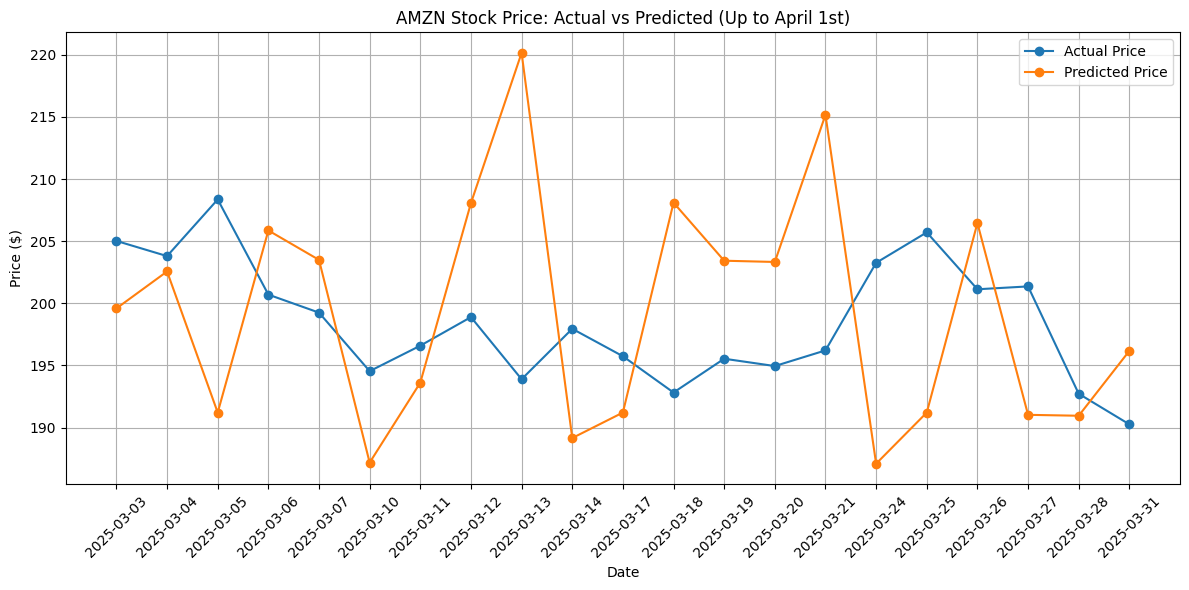

In [ ]:
# Filter data before April 1st for training
train_data = data[data['date'] < '2025-03-01']
test_data = data[data['date'] >= '2025-03-01']

# Features: sentiment data and other relevant features
features = ['positive', 'negative', 'neutral', 'culmination']
target = 'close'

# Prepare training data
X_train = train_data[features]
y_train = train_data[target]

# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
X_test = test_data[features]
predictions = rf_model.predict(X_test)

# Calculate error
mae = mean_absolute_error(test_data[target], predictions)
print(f"Mean Absolute Error: ${mae:.2f}")

# Print actual vs predicted prices
results = pd.DataFrame({
    'Date': test_data['date'],
    'Actual Price': test_data[target],
    'Predicted Price': predictions
})
print("\nPredictions:")
print(results)
# Filter results to exclude dates past April 1st
filtered_results = results[results['Date'] < '2025-04-01']

# Create a figure with appropriate size
plt.figure(figsize=(12, 6))

# Plot actual vs predicted prices
plt.plot(filtered_results['Date'], filtered_results['Actual Price'], label='Actual Price', marker='o')
plt.plot(filtered_results['Date'], filtered_results['Predicted Price'], label='Predicted Price', marker='o')

# Customize the plot
plt.title('AMZN Stock Price: Actual vs Predicted (Up to April 1st)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()